In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,6)
from collections import defaultdict, deque
from calendar import month_name

import seaborn as sns

import math

In [3]:
import glob

# df = pd.read_csv('../data/raw/euro-2024-2025/B1.csv')
csv_2024 = glob.glob('../data/raw/euro-2024-2025/*.csv')
csv_2023 = glob.glob('../data/raw/euro-2023-2024/*.csv')
csv_2022 = glob.glob('../data/raw/euro-2022-2023/*.csv')
csv_2021 = glob.glob('../data/raw/euro-2021-2022/*.csv')
csv_2020 = glob.glob('../data/raw/euro-2020-2021/*.csv')


def load_csv_files(file_list, index):
    dataframes = pd.DataFrame()
    for file in file_list:
        try:
            non_ascii_pattern = r'[^\x00-\x7F]+'
            df_temp = pd.read_csv(file, encoding='latin1')
            for col in df_temp.select_dtypes(include='object').columns:
                df_temp[col] = df_temp[col].str.replace(non_ascii_pattern, '', regex=True)
            dataframes = pd.concat([dataframes, df_temp], ignore_index=True)
        except Exception as e:
            print(f"Error reading at index {index} for file {file}: {e}")
    return dataframes


df1=df2=df3=df4=df5=pd.DataFrame()

for i, csv in enumerate([csv_2024, csv_2023, csv_2022, csv_2021, csv_2020], start=1):
    vars()[f'df{i}'] = load_csv_files(csv, i)
    
for i in range(1, 6):
    print(f"DataFrame df{i} shape: {vars()[f'df{i}'].shape}")  # Print the shape of each DataFrame

df1['Div'] = df1['ï»¿Div']
df1.drop('ï»¿Div', axis=1, inplace=True)

DataFrame df1 shape: (7681, 123)
DataFrame df2 shape: (7800, 106)
DataFrame df3 shape: (7829, 106)
DataFrame df4 shape: (7822, 108)
DataFrame df5 shape: (7648, 106)


In [ ]:
df1.columns.tolist()

In [4]:
relevant_columns = ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 
                    # 'HTHG', 'HTAG', 'HTR', 'HST', 'AST', 'HC', 'AC', 'HR', 'AR'
                    ]

ft_stat_df1 = df1[relevant_columns]

# assigning shots on target to na columns
# zero_column_field = ['HR','AR','HTHG','HTAG','HC','AC']

# ft_stat_df1['HST'].fillna(np.ceil(ft_stat_df1['FTHG']*1.5),inplace=True)
# ft_stat_df1['AST'].fillna(np.ceil(ft_stat_df1['FTAG']*1.5),inplace=True)
# ft_stat_df1[zero_column_field] = ft_stat_df1[zero_column_field].fillna(0)
ft_stat_df1['Date'] = pd.to_datetime(ft_stat_df1['Date'], dayfirst=True)

# dropping row where htr is na
# ft_stat_df1 = ft_stat_df1[~ft_stat_df1['HTR'].isna()]

/var/folders/20/rjmqgh8s6b5026966rk_2tt80000gn/T/ipykernel_68797/511736574.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ft_stat_df1['Date'] = pd.to_datetime(ft_stat_df1['Date'], dayfirst=True)


In [136]:
ft_stat_df1.head(5)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,B1,2024-07-27,19:45,Anderlecht,St Truiden,1,0,H
1,B1,2024-07-27,17:15,Beerschot VA,Oud-Heverlee Leuven,0,0,D
2,B1,2024-07-28,17:30,Charleroi,Antwerp,0,1,A
3,B1,2024-07-26,19:45,Club Brugge,Mechelen,1,1,D
4,B1,2024-07-27,15:00,Dender,St. Gilloise,0,0,D


In [159]:
# playing stats for teams before match, goal against (ga), gf, w,d,l, gp, pts, form, home_perf, away_perf

def play_stat(df):
    processed_df = pd.DataFrame(columns=df.columns.to_list() + ['HomeGF','AwayGF','HomeGA','AwayGA','HomePt','AwayPt', 'HomeForm','AwayForm','HomeGP','AwayGP','HomeW','HomeD','HomeL','AwayW','AwayD','AwayL','HomePerf','AwayPerf'])
    
    form_window = 5
    
    team_stats = defaultdict(lambda:{'gf':0, 'ga':0, 'pt':0, 'gp':0, 'w':0, 'd':0, 'l':0, 'form':deque(maxlen=form_window), 'hperf':deque(maxlen=form_window),'aperf':deque(maxlen=form_window)})
    
    for div, group in df.groupby(['Div', 'Date'], sort=True):
        counter = 0
        for row in group.itertuples():
            home = row.HomeTeam
            away = row.AwayTeam
            index = row.Index
            hg = row.FTHG
            ag = row.FTAG

            features = {}
            for side, team, is_home in [('Home', home, True), ('Away', away, False)]:
                stats = team_stats[team]
                features |= {
                    f'{side}Pt': stats['pt'],
                    f'{side}GF': stats['gf'],
                    f'{side}GA': stats['ga'],
                    f'{side}Form': '-'.join(stats['form']),
                    f'{side}GP': stats['gp'],
                    f'{side}W': stats['w'],
                    f'{side}D': stats['d'],
                    f'{side}L': stats['l'],    
                }
                if is_home:
                    features['HomePerf'] = '-'.join(stats['hperf'])
                else:
                    features['AwayPerf'] = '-'.join(stats['aperf'])



            processed_df.loc[len(processed_df)] = {**row._asdict(), **features}
            
            def update_stats(home, away, hg, ag):
                # goals
                team_stats[home]['gf'] += hg
                team_stats[home]['ga'] += ag
                team_stats[away]['gf'] += ag
                team_stats[away]['ga'] += hg

                # games played
                team_stats[home]['gp'] += 1
                team_stats[away]['gp'] += 1

                # result
                if hg > ag:
                    result = ('W', 'L', 3, 0)
                elif hg < ag:
                    result = ('L', 'W', 0, 3) 
                else:
                    result = ('D', 'D', 1, 1)
                    
                for team, form, pts, is_home in [
                    (home, result[0], result[2], True),
                    (away, result[1], result[3], False)
                ]:
                    team_stats[team]['pt'] += pts
                    team_stats[team][form.lower()] += 1
                    team_stats[team]['form'].append(form)
                    if is_home:
                        team_stats[team]['hperf'].append(form)
                    else:
                        team_stats[team]['aperf'].append(form)
            
               
            update_stats(home, away, hg, ag)



    return processed_df
play_stats_df1 = play_stat(ft_stat_df1)
# play_stats_df2 = play_stat(ft_stat_df2)
# play_stats_df3 = play_stat(ft_stat_df3)
# play_stats_df4 = play_stat(ft_stat_df4)
# play_stats_df5 = play_stat(ft_stat_df5)
# play_stats_df1.tail(10)[['Date','HomeTeam','AwayTeam','HomeGF','AwayGF','HomeGA','AwayGA','HomePt','AwayPt', 'HomeForm','AwayForm','HomeGP','AwayGP','HomeW','HomeD','HomeL','AwayW','AwayD','AwayL','HomePerf','AwayPerf']]
# play_stats_df1.head(50)[['Date','HomeTeam','AwayTeam','FTR', 'HomeForm','AwayForm','HomeGP','AwayGP', 'HomePerf','AwayPerf']]
play_stats_df1.head()[['Date','HomeTeam','AwayTeam','FTR', 'HomeForm','AwayForm','HomeGP','AwayGP', 'HomePerf','AwayPerf']]

,Date,HomeTeam,AwayTeam,FTR,HomeForm,AwayForm,HomeGP,AwayGP,HomePerf,AwayPerf
0,2024-07-26,Club Brugge,Mechelen,D,,,0,0,,
1,2024-07-27,Anderlecht,St Truiden,H,,,0,0,,
2,2024-07-27,Beerschot VA,Oud-Heverlee Leuven,D,,,0,0,,
3,2024-07-27,Dender,St. Gilloise,D,,,0,0,,
4,2024-07-28,Charleroi,Antwerp,A,,,0,0,,


In [164]:
# playing stats for teams before match, h2h, h2hath (h2h at home)

def add_h2h_stats(df):
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Create a unique matchup key that’s the same regardless of home/away order
    df['MatchKey'] = df.apply(
        lambda x: '-'.join(sorted([x['HomeTeam'], x['AwayTeam']])), axis=1
    )

    # Encode outcomes numerically for easier aggregation
    df['HomeWin'] = (df['FTR'] == 'H').astype(int)
    df['AwayWin'] = (df['FTR'] == 'A').astype(int)
    df['Draw'] = (df['FTR'] == 'D').astype(int)

    # Group by matchup
    grouped = df.groupby('MatchKey', group_keys=False)

    # For each matchup, compute cumulative counts before current match
    df['H2H_H_W'] = grouped['HomeWin'].cumsum().shift(1).fillna(0)
    df['H2H_A_W'] = grouped['AwayWin'].cumsum().shift(1).fillna(0)
    df['H2H_D'] = grouped['Draw'].cumsum().shift(1).fillna(0)
    df['H2H_Total'] = df[['H2H_H_W', 'H2H_A_W', 'H2H_D']].sum(axis=1)

    return df.drop(columns=['MatchKey'])

play_stats_df1 = add_h2h_stats(play_stats_df1)

/var/folders/20/rjmqgh8s6b5026966rk_2tt80000gn/T/ipykernel_68797/1805458636.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(form_matrix.applymap(lambda x: 1 if 'W' in x else (-1 if 'L' in x else 0)), cmap='coolwarm', center=0)


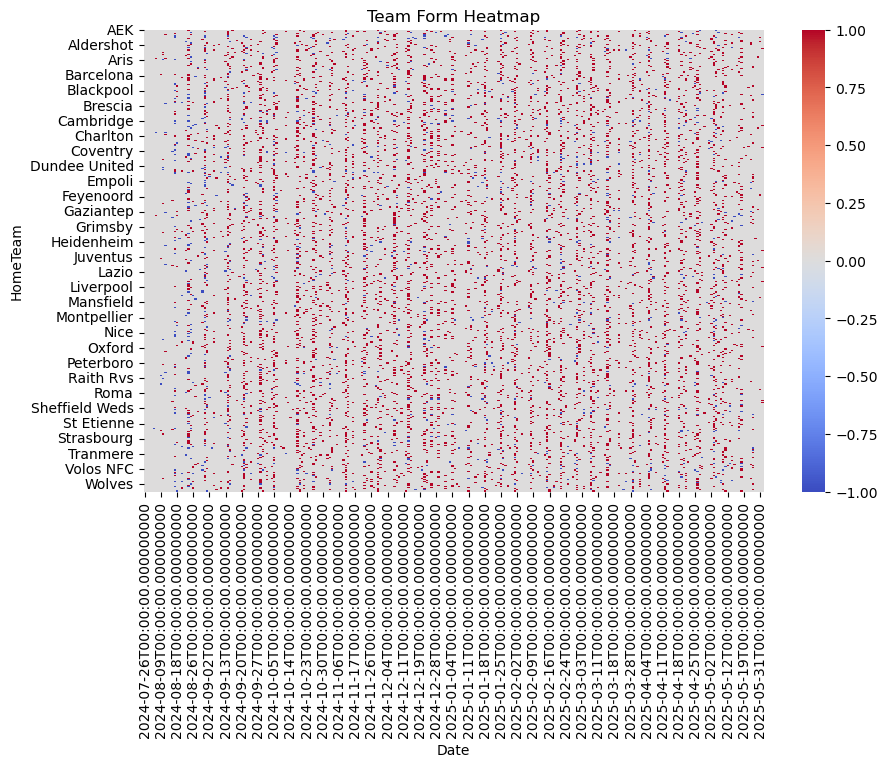

In [176]:

form_matrix = play_stats_df1.pivot_table(index='HomeTeam', columns='Date', values='HomeForm', aggfunc=lambda x: ''.join(x))
form_matrix = form_matrix.fillna('')
sns.heatmap(form_matrix.applymap(lambda x: 1 if 'W' in x else (-1 if 'L' in x else 0)), cmap='coolwarm', center=0)
plt.title('Team Form Heatmap')
plt.show()


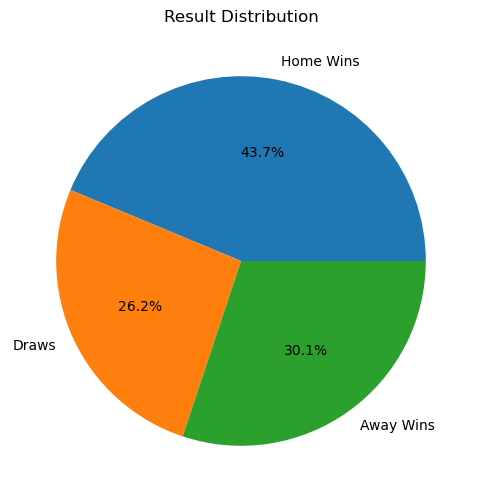

In [177]:
## Performance Distribution

play_stats_df1[['HomeWin','Draw','AwayWin']].sum().plot.pie(
    autopct='%1.1f%%', labels=['Home Wins','Draws','Away Wins'], title='Result Distribution'
)
plt.show()


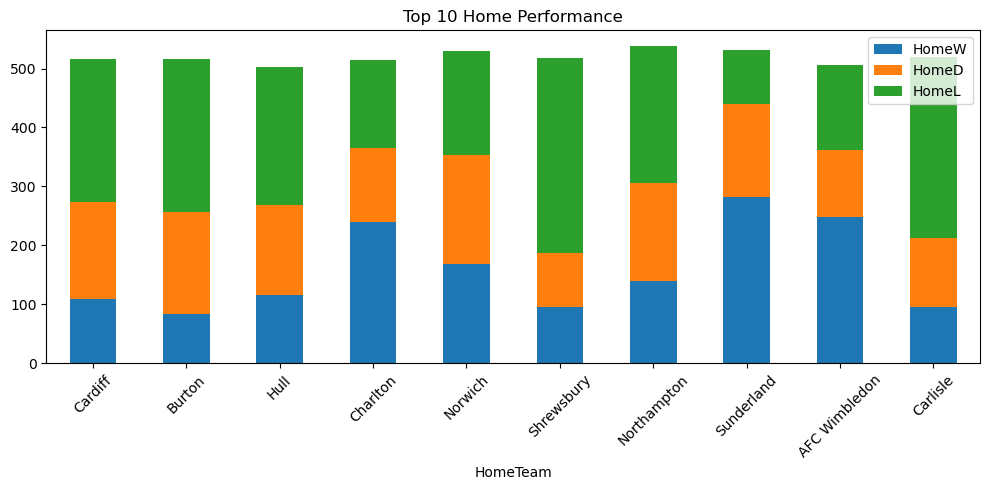

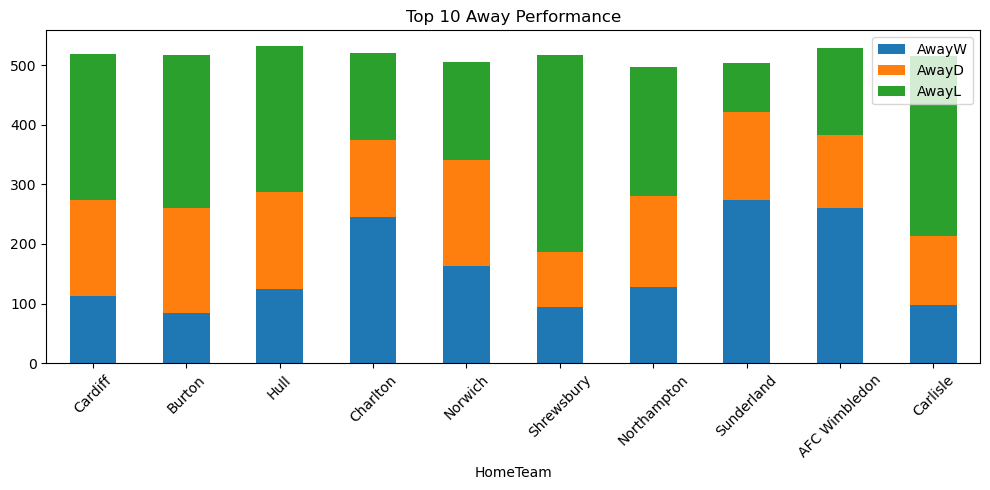

In [182]:
## Team Efficiency to see who converts chances into results effectively.

# play_stats_df1['Efficiency'] = play_stats_df1['HomePt'] / play_stats_df1['HomeGF']
# play_stats_df1.groupby('HomeTeam')['Efficiency'].mean().sort_values(ascending=False).head(10).plot.bar(title='Most Efficient Teams (Pts per Goal)')
# plt.show()

## League Comparison

# play_stats_df1.groupby('Div')[['HomeWin','AwayWin','Draw']].mean().plot.bar(title='League-Level Outcome Rates')
# plt.show()

## Form Comparison (Home vs Away)

home_perf = play_stats_df1.groupby('HomeTeam')[['HomeW','HomeD','HomeL']].sum()
away_perf = play_stats_df1.groupby('AwayTeam')[['AwayW','AwayD','AwayL']].sum()

# top 10 teams by total games played
top_teams = (
    (home_perf.sum(axis=1) + away_perf.sum(axis=1))
    .sort_values(ascending=False)
    .head(10)
    .index
)

home_perf.loc[top_teams].plot.bar(stacked=True, figsize=(10,5), title='Top 10 Home Performance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

away_perf.loc[top_teams].plot.bar(stacked=True, figsize=(10,5), title='Top 10 Away Performance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [184]:
play_stats_df1.columns

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HomeGF', 'AwayGF', 'HomeGA', 'AwayGA', 'HomePt', 'AwayPt', 'HomeForm',
       'AwayForm', 'HomeGP', 'AwayGP', 'HomeW', 'HomeD', 'HomeL', 'AwayW',
       'AwayD', 'AwayL', 'HomePerf', 'AwayPerf', 'HomeWin', 'AwayWin', 'Draw',
       'H2H_H_W', 'H2H_A_W', 'H2H_D', 'H2H_Total', 'Efficiency'],
      dtype='object')

In [217]:
# convert form to nominal features for modelling
## We use weighted score, it helps quantify recent form while giving more importance to recent matches
def form_weighted_score(form_deque):
    # assign 3/1/0 for W/D/L
    points = {'W': 3, 'D': 1, 'L': 0}
    results = [r for r in list(form_deque) if r in points]
    if not results:
        return 0
    form_points = np.array([points[r] for r in results])
    # descending weights (recent matches get higher weight)
    weights = np.linspace(1, 0.2, len(form_points))  ######### to .2 to be played around with later, boy!
    
    return np.dot(form_points, weights) / weights.sum()  # weighted sum

play_stats_df1['HomeFormScore'] = play_stats_df1['HomeForm'].apply(form_weighted_score)
play_stats_df1['HomeAtHomeFormScore'] = play_stats_df1['HomePerf'].apply(form_weighted_score)
play_stats_df1['AwayFormScore'] = play_stats_df1['AwayForm'].apply(form_weighted_score)
play_stats_df1['AwayAtAwayFormScore'] = play_stats_df1['AwayPerf'].apply(form_weighted_score)


play_stats_df1.columns

Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HomeGF', 'AwayGF', 'HomeGA', 'AwayGA', 'HomePt', 'AwayPt', 'HomeForm',
       'AwayForm', 'HomeGP', 'AwayGP', 'HomeW', 'HomeD', 'HomeL', 'AwayW',
       'AwayD', 'AwayL', 'HomePerf', 'AwayPerf', 'HomeWin', 'AwayWin', 'Draw',
       'H2H_H_W', 'H2H_A_W', 'H2H_D', 'H2H_Total', 'Efficiency',
       'HomeFormScore', 'HomePerfScore', 'AwayFormScore', 'AwayPerfScore',
       'HomeAtHomeFormScore', 'AwayAtAwayFormScore'],
      dtype='object')

In [223]:
    
# setting target column for our model. i'm encoding the target to `0,1 or 2`
# 0 means home team win, 1 means draw and 2 is away win

play_stats_df1['target'] = play_stats_df1['FTR'].map({'H': 0, 'D': 1, 'A': 2})


# df_modelling.tail(1), i want to see all the columns in the df

with pd.option_context('display.max_columns', None):
    print(play_stats_df1.sample(1))

     Div       Date   Time   HomeTeam   AwayTeam  FTHG  FTAG FTR  HomeGF  \
6270  N1 2025-04-02  19:00  Feyenoord  Groningen     4     1   H      57   

      AwayGF  HomeGA  AwayGA  HomePt  AwayPt   HomeForm   AwayForm  HomeGP  \
6270      25      31      34      50      32  D-W-D-W-W  W-W-D-W-D      26   

      AwayGP  HomeW  HomeD  HomeL  AwayW  AwayD  AwayL   HomePerf   AwayPerf  \
6270      26     14      8      4      8      8     10  L-W-W-D-W  L-D-L-W-D   

      HomeWin  AwayWin  Draw  H2H_H_W  H2H_A_W  H2H_D  H2H_Total  Efficiency  \
6270        1        0     0      3.0      0.0    1.0        4.0    0.877193   

      HomeFormScore  HomePerfScore  AwayFormScore  AwayPerfScore  \
6270       1.933333       1.733333       2.466667       0.733333   

      HomeAtHomeFormScore  AwayAtAwayFormScore  target  
6270             1.733333             0.733333       0  


In [ ]:
from sklearn.preprocessing import LabelEncoder

# You know what, let's drop some of these columns
play_stats_df1 = play_stats_df1.drop([
    'FTR', 'FTHG', 'FTAG', 'Date', 'Div', 'Time', 'HomeForm', 'AwayForm', 'HomePerf', 'AwayPerf', 
    'Efficiency', 'H2H_Total'], axis=1)

# Let's label encode the team names

le = LabelEncoder()
play_stats_df1['HomeTeam'] = le.fit_transform(play_stats_df1['HomeTeam'])
play_stats_df1['AwayTeam'] = le.fit_transform(play_stats_df1['AwayTeam'])


In [ ]:
# play_stats_df1['target'].value_counts(normalize=True)


# Let's do Feature Scaling, shall we?. No, we'll use random forest so no need i guess 🤷‍♀️

# from sklearn.preprocessing import StandardScaler

# test_df = play_stats_df1.head(500)

# num_cols = test_df.select_dtypes(include=['float64', 'int64']).columns
# scaler = StandardScaler()

# coming back to this!

In [292]:
# Train Test Split
from sklearn.model_selection import train_test_split


X = play_stats_df1.drop('target', axis='columns')
y = play_stats_df1['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)



In [ ]:
# play_stats_df1.info()
# play_stats_df1.isna().sum()
# X_train.head()

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=40, random_state=1, min_samples_split=10)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)



0

In [ ]:

# from sklearn.model_selection import cross_val_score
# cross_val_score(rf, X, y, cv=5)


1.0